In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13442177576959986881, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9214062756
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4309517442416903638
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
from sklearn.metrics import log_loss
import sys
import time
import math
import os
import pandas as pd
from keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.regularizers import l2

from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score

import matplotlib.pyplot as plt
from keras.layers import Input, concatenate
from keras import optimizers, metrics, models
from keras.layers import Input, Flatten, Dense

%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0


In [5]:
batch_size = 32
img_height, img_width = 128, 128
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
train_dir = 'data_augmented/train/'
test_dir = 'data_augmented/test'

In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.3,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 46475 images belonging to 6 classes.
Found 19915 images belonging to 6 classes.
Found 13578 images belonging to 6 classes.


In [13]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 46475
nb_validation_samples: 19915
nb_test_samples: 13578

predict_size_train: 1453
predict_size_validation: 623
predict_size_test: 425

 num_classes: 6


In [8]:
# os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "Xception_InceptionV3_augmented_descriptors"

In [9]:
# vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
# inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
# vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
# resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
# inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
# nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
# nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
# mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"

In [10]:
# from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet

In [14]:
input_tensor = Input(shape = input_shape)  

base_model1=InceptionV3(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model2=Xception(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

merge = concatenate([x1, x2])
predictions = Dense(num_classes, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [15]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [16]:
c1 = model.layers[11].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[21].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[28].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[51].output
c4 = GlobalAveragePooling2D()(c4) 

c5 = model.layers[84].output
c5 = GlobalAveragePooling2D()(c5) 

c6 = model.layers[103].output
c6 = GlobalAveragePooling2D()(c6) 

c7 = model.layers[117].output
c7 = GlobalAveragePooling2D()(c7) 

c8 = model.layers[129].output
c8 = GlobalAveragePooling2D()(c8) 

c9 = model.layers[143].output
c9 = GlobalAveragePooling2D()(c9) 

c10 = model.layers[162].output
c10 = GlobalAveragePooling2D()(c10) 

c11 = model.layers[210].output
c11 = GlobalAveragePooling2D()(c11) 

c12 = model.layers[258].output
c12 = GlobalAveragePooling2D()(c12) 

c13 = model.layers[306].output
c13 = GlobalAveragePooling2D()(c13) 

c14 = model.layers[356].output
c14 = GlobalAveragePooling2D()(c14) 

c15 = model.layers[377].output
c15 = GlobalAveragePooling2D()(c15) 

c16 = model.layers[415].output
c16 = GlobalAveragePooling2D()(c16) 

c17 = model.layers[421].output
c17 = GlobalAveragePooling2D()(c17) 

con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [17]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [18]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [19]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [21]:
import tensorflow as tf
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))

reset_keras_tf_session()

In [22]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [23]:
dropout_rate = 0.7

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.5, beta_2=0.999)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 46475 samples, validate on 19915 samples
Epoch 1/1000
 - 6s - loss: 0.7039 - acc: 0.7481 - val_loss: 0.6726 - val_acc: 0.7372
Epoch 2/1000
 - 5s - loss: 0.4717 - acc: 0.8340 - val_loss: 0.6694 - val_acc: 0.7406
Epoch 3/1000
 - 5s - loss: 0.4236 - acc: 0.8505 - val_loss: 0.5463 - val_acc: 0.7988
Epoch 4/1000
 - 5s - loss: 0.3923 - acc: 0.8626 - val_loss: 0.6119 - val_acc: 0.7769
Epoch 5/1000
 - 5s - loss: 0.3742 - acc: 0.8689 - val_loss: 0.6583 - val_acc: 0.7602
Epoch 6/1000
 - 5s - loss: 0.3604 - acc: 0.8711 - val_loss: 0.6290 - val_acc: 0.7718
Epoch 7/1000
 - 5s - loss: 0.3451 - acc: 0.8781 - val_loss: 0.5932 - val_acc: 0.7906
Epoch 8/1000
 - 5s - loss: 0.3403 - acc: 0.8780 - val_loss: 0.5809 - val_acc: 0.7897
Epoch 9/1000
 - 6s - loss: 0.3316 - acc: 0.8817 - val_loss: 0.6568 - val_acc: 0.7623
Epoch 10/1000
 - 6s - loss: 0.3243 - acc: 0.8841 - val_loss: 0.5526 - val_acc: 0.8016
Epoch 11/1000
 - 5s - loss: 0.3165 - acc: 0.8875 - val_loss: 0.5587 - val_acc: 0.7958
Epoch 12/1000

Epoch 96/1000
 - 5s - loss: 0.1916 - acc: 0.9313 - val_loss: 0.6006 - val_acc: 0.8154
Epoch 97/1000
 - 5s - loss: 0.1919 - acc: 0.9303 - val_loss: 0.6000 - val_acc: 0.8152
Epoch 98/1000
 - 5s - loss: 0.1916 - acc: 0.9306 - val_loss: 0.6468 - val_acc: 0.8070
Epoch 99/1000
 - 5s - loss: 0.1915 - acc: 0.9310 - val_loss: 0.6707 - val_acc: 0.8056
Epoch 100/1000
 - 5s - loss: 0.1891 - acc: 0.9314 - val_loss: 0.7104 - val_acc: 0.8168
Epoch 101/1000
 - 5s - loss: 0.1907 - acc: 0.9299 - val_loss: 0.7047 - val_acc: 0.8138
Epoch 102/1000
 - 5s - loss: 0.1891 - acc: 0.9327 - val_loss: 0.7045 - val_acc: 0.8077
Epoch 103/1000
 - 5s - loss: 0.1878 - acc: 0.9320 - val_loss: 0.6386 - val_acc: 0.8189
Epoch 104/1000
 - 5s - loss: 0.1903 - acc: 0.9304 - val_loss: 0.6977 - val_acc: 0.8088
Epoch 105/1000
 - 5s - loss: 0.1882 - acc: 0.9316 - val_loss: 0.6315 - val_acc: 0.8240
Epoch 106/1000
 - 5s - loss: 0.1868 - acc: 0.9332 - val_loss: 0.6247 - val_acc: 0.8169
Epoch 107/1000
 - 5s - loss: 0.1882 - acc: 0.93

Epoch 191/1000
 - 5s - loss: 0.1569 - acc: 0.9424 - val_loss: 0.7944 - val_acc: 0.8229
Epoch 192/1000
 - 5s - loss: 0.1559 - acc: 0.9432 - val_loss: 0.7344 - val_acc: 0.8154
Epoch 193/1000
 - 5s - loss: 0.1561 - acc: 0.9429 - val_loss: 0.7851 - val_acc: 0.8134
Epoch 194/1000
 - 5s - loss: 0.1543 - acc: 0.9434 - val_loss: 0.7327 - val_acc: 0.8185
Epoch 195/1000
 - 5s - loss: 0.1542 - acc: 0.9442 - val_loss: 0.7122 - val_acc: 0.8213
Epoch 196/1000
 - 5s - loss: 0.1551 - acc: 0.9431 - val_loss: 0.6849 - val_acc: 0.8211
Epoch 197/1000
 - 5s - loss: 0.1534 - acc: 0.9439 - val_loss: 0.7185 - val_acc: 0.8158
Epoch 198/1000
 - 5s - loss: 0.1513 - acc: 0.9438 - val_loss: 0.6770 - val_acc: 0.8198
Epoch 199/1000
 - 5s - loss: 0.1546 - acc: 0.9426 - val_loss: 0.8049 - val_acc: 0.8190
Epoch 200/1000
 - 5s - loss: 0.1545 - acc: 0.9433 - val_loss: 0.7660 - val_acc: 0.8263
Epoch 201/1000
 - 5s - loss: 0.1548 - acc: 0.9431 - val_loss: 0.6873 - val_acc: 0.8129
Epoch 202/1000
 - 5s - loss: 0.1545 - acc: 

 - 5s - loss: 0.1382 - acc: 0.9492 - val_loss: 0.8122 - val_acc: 0.8199
Epoch 286/1000
 - 5s - loss: 0.1357 - acc: 0.9493 - val_loss: 0.8207 - val_acc: 0.8221
Epoch 287/1000
 - 5s - loss: 0.1345 - acc: 0.9493 - val_loss: 0.8265 - val_acc: 0.8188
Epoch 288/1000
 - 5s - loss: 0.1357 - acc: 0.9500 - val_loss: 0.8357 - val_acc: 0.8123
Epoch 289/1000
 - 5s - loss: 0.1363 - acc: 0.9482 - val_loss: 0.8180 - val_acc: 0.8246
Epoch 290/1000
 - 5s - loss: 0.1356 - acc: 0.9490 - val_loss: 0.8776 - val_acc: 0.8154
Epoch 291/1000
 - 5s - loss: 0.1351 - acc: 0.9497 - val_loss: 0.8084 - val_acc: 0.8233
Epoch 292/1000
 - 5s - loss: 0.1346 - acc: 0.9495 - val_loss: 0.8437 - val_acc: 0.8070
Epoch 293/1000
 - 5s - loss: 0.1368 - acc: 0.9486 - val_loss: 0.8243 - val_acc: 0.8165
Epoch 294/1000
 - 5s - loss: 0.1340 - acc: 0.9497 - val_loss: 0.8180 - val_acc: 0.8150
Epoch 295/1000
 - 5s - loss: 0.1345 - acc: 0.9508 - val_loss: 0.8168 - val_acc: 0.8217
Epoch 296/1000
 - 5s - loss: 0.1351 - acc: 0.9501 - val_lo

Epoch 380/1000
 - 5s - loss: 0.1213 - acc: 0.9544 - val_loss: 0.8827 - val_acc: 0.8271
Epoch 381/1000
 - 5s - loss: 0.1248 - acc: 0.9525 - val_loss: 0.9584 - val_acc: 0.8146
Epoch 382/1000
 - 5s - loss: 0.1218 - acc: 0.9544 - val_loss: 0.8240 - val_acc: 0.8259
Epoch 383/1000
 - 5s - loss: 0.1216 - acc: 0.9544 - val_loss: 0.9197 - val_acc: 0.8173
Epoch 384/1000
 - 5s - loss: 0.1228 - acc: 0.9530 - val_loss: 0.9758 - val_acc: 0.8149
Epoch 385/1000
 - 5s - loss: 0.1241 - acc: 0.9535 - val_loss: 0.9193 - val_acc: 0.8126
Epoch 386/1000
 - 5s - loss: 0.1207 - acc: 0.9548 - val_loss: 0.8667 - val_acc: 0.8248
Epoch 387/1000
 - 5s - loss: 0.1225 - acc: 0.9548 - val_loss: 0.8895 - val_acc: 0.8190
Epoch 388/1000
 - 5s - loss: 0.1211 - acc: 0.9539 - val_loss: 0.8215 - val_acc: 0.8305
Epoch 389/1000
 - 5s - loss: 0.1219 - acc: 0.9551 - val_loss: 0.8940 - val_acc: 0.8187
Epoch 390/1000
 - 5s - loss: 0.1235 - acc: 0.9536 - val_loss: 0.8251 - val_acc: 0.8247
Epoch 391/1000
 - 5s - loss: 0.1203 - acc: 

 - 5s - loss: 0.1151 - acc: 0.9563 - val_loss: 0.8030 - val_acc: 0.8313
Epoch 475/1000
 - 5s - loss: 0.1130 - acc: 0.9561 - val_loss: 0.9776 - val_acc: 0.8170
Epoch 476/1000
 - 5s - loss: 0.1155 - acc: 0.9557 - val_loss: 0.9206 - val_acc: 0.8281
Epoch 477/1000
 - 5s - loss: 0.1131 - acc: 0.9571 - val_loss: 0.9583 - val_acc: 0.8260
Epoch 478/1000
 - 5s - loss: 0.1093 - acc: 0.9590 - val_loss: 1.0848 - val_acc: 0.8081
Epoch 479/1000
 - 5s - loss: 0.1134 - acc: 0.9572 - val_loss: 0.9300 - val_acc: 0.8202
Epoch 480/1000
 - 5s - loss: 0.1156 - acc: 0.9562 - val_loss: 0.8440 - val_acc: 0.8307
Epoch 481/1000
 - 5s - loss: 0.1119 - acc: 0.9570 - val_loss: 1.0238 - val_acc: 0.8162
Epoch 482/1000
 - 5s - loss: 0.1140 - acc: 0.9567 - val_loss: 0.9948 - val_acc: 0.8224
Epoch 483/1000
 - 5s - loss: 0.1118 - acc: 0.9571 - val_loss: 0.9569 - val_acc: 0.8209
Epoch 484/1000
 - 5s - loss: 0.1123 - acc: 0.9585 - val_loss: 0.9294 - val_acc: 0.8282
Epoch 485/1000
 - 5s - loss: 0.1131 - acc: 0.9564 - val_lo

Epoch 569/1000
 - 5s - loss: 0.1069 - acc: 0.9594 - val_loss: 1.0443 - val_acc: 0.8141
Epoch 570/1000
 - 5s - loss: 0.1068 - acc: 0.9591 - val_loss: 1.0162 - val_acc: 0.8189
Epoch 571/1000
 - 5s - loss: 0.1065 - acc: 0.9592 - val_loss: 0.9679 - val_acc: 0.8248
Epoch 572/1000
 - 5s - loss: 0.1052 - acc: 0.9595 - val_loss: 1.0505 - val_acc: 0.8272
Epoch 573/1000
 - 5s - loss: 0.1042 - acc: 0.9594 - val_loss: 1.0709 - val_acc: 0.8148
Epoch 574/1000
 - 5s - loss: 0.1041 - acc: 0.9602 - val_loss: 1.0345 - val_acc: 0.8221
Epoch 575/1000
 - 5s - loss: 0.1053 - acc: 0.9598 - val_loss: 1.0892 - val_acc: 0.8154
Epoch 576/1000
 - 5s - loss: 0.1023 - acc: 0.9609 - val_loss: 1.0181 - val_acc: 0.8216
Epoch 577/1000
 - 5s - loss: 0.1063 - acc: 0.9595 - val_loss: 1.1043 - val_acc: 0.8191
Epoch 578/1000
 - 5s - loss: 0.1026 - acc: 0.9602 - val_loss: 1.0592 - val_acc: 0.8197
Epoch 579/1000
 - 5s - loss: 0.1042 - acc: 0.9596 - val_loss: 1.0017 - val_acc: 0.8205
Epoch 580/1000
 - 5s - loss: 0.1063 - acc: 

 - 5s - loss: 0.0989 - acc: 0.9623 - val_loss: 1.1418 - val_acc: 0.8219
Epoch 664/1000
 - 5s - loss: 0.0978 - acc: 0.9622 - val_loss: 1.0107 - val_acc: 0.8271
Epoch 665/1000
 - 5s - loss: 0.1010 - acc: 0.9607 - val_loss: 1.1011 - val_acc: 0.8251
Epoch 666/1000
 - 5s - loss: 0.0973 - acc: 0.9617 - val_loss: 1.0172 - val_acc: 0.8225
Epoch 667/1000
 - 5s - loss: 0.0985 - acc: 0.9632 - val_loss: 1.0511 - val_acc: 0.8264
Epoch 668/1000
 - 6s - loss: 0.0997 - acc: 0.9618 - val_loss: 1.1073 - val_acc: 0.8154
Epoch 669/1000
 - 6s - loss: 0.0989 - acc: 0.9615 - val_loss: 1.0173 - val_acc: 0.8151
Epoch 670/1000
 - 6s - loss: 0.0973 - acc: 0.9623 - val_loss: 1.0987 - val_acc: 0.8245
Epoch 671/1000
 - 6s - loss: 0.1001 - acc: 0.9620 - val_loss: 1.0811 - val_acc: 0.8225
Epoch 672/1000
 - 5s - loss: 0.0995 - acc: 0.9618 - val_loss: 1.0350 - val_acc: 0.8316
Epoch 673/1000
 - 5s - loss: 0.1005 - acc: 0.9614 - val_loss: 1.0421 - val_acc: 0.8234
Epoch 674/1000
 - 5s - loss: 0.1015 - acc: 0.9614 - val_lo

Epoch 758/1000
 - 6s - loss: 0.0968 - acc: 0.9618 - val_loss: 1.0311 - val_acc: 0.8257
Epoch 759/1000
 - 6s - loss: 0.0966 - acc: 0.9630 - val_loss: 1.1684 - val_acc: 0.8207
Epoch 760/1000
 - 6s - loss: 0.0967 - acc: 0.9626 - val_loss: 1.1519 - val_acc: 0.8245
Epoch 761/1000
 - 6s - loss: 0.0959 - acc: 0.9625 - val_loss: 1.1488 - val_acc: 0.8250
Epoch 762/1000
 - 6s - loss: 0.0943 - acc: 0.9646 - val_loss: 1.1941 - val_acc: 0.8240
Epoch 763/1000
 - 5s - loss: 0.0945 - acc: 0.9632 - val_loss: 1.1205 - val_acc: 0.8249
Epoch 764/1000
 - 5s - loss: 0.0933 - acc: 0.9639 - val_loss: 1.1342 - val_acc: 0.8200
Epoch 765/1000
 - 5s - loss: 0.0950 - acc: 0.9639 - val_loss: 1.1066 - val_acc: 0.8175
Epoch 766/1000
 - 5s - loss: 0.0958 - acc: 0.9628 - val_loss: 1.1515 - val_acc: 0.8218
Epoch 767/1000
 - 5s - loss: 0.0943 - acc: 0.9630 - val_loss: 1.0739 - val_acc: 0.8295
Epoch 768/1000
 - 5s - loss: 0.0952 - acc: 0.9622 - val_loss: 0.9827 - val_acc: 0.8338
Epoch 769/1000
 - 5s - loss: 0.0949 - acc: 

 - 7s - loss: 0.0893 - acc: 0.9661 - val_loss: 1.1000 - val_acc: 0.8293
Epoch 853/1000
 - 6s - loss: 0.0899 - acc: 0.9659 - val_loss: 1.0651 - val_acc: 0.8233
Epoch 854/1000
 - 6s - loss: 0.0888 - acc: 0.9660 - val_loss: 1.1450 - val_acc: 0.8202
Epoch 855/1000
 - 6s - loss: 0.0917 - acc: 0.9646 - val_loss: 1.1151 - val_acc: 0.8269
Epoch 856/1000
 - 6s - loss: 0.0909 - acc: 0.9648 - val_loss: 1.1145 - val_acc: 0.8206
Epoch 857/1000
 - 6s - loss: 0.0920 - acc: 0.9637 - val_loss: 1.0951 - val_acc: 0.8269
Epoch 858/1000
 - 6s - loss: 0.0909 - acc: 0.9650 - val_loss: 1.1338 - val_acc: 0.8245
Epoch 859/1000
 - 6s - loss: 0.0904 - acc: 0.9647 - val_loss: 1.1028 - val_acc: 0.8295
Epoch 860/1000
 - 6s - loss: 0.0911 - acc: 0.9642 - val_loss: 1.1210 - val_acc: 0.8231
Epoch 861/1000
 - 6s - loss: 0.0910 - acc: 0.9650 - val_loss: 1.0796 - val_acc: 0.8282
Epoch 862/1000
 - 6s - loss: 0.0901 - acc: 0.9653 - val_loss: 1.2650 - val_acc: 0.8201
Epoch 863/1000
 - 6s - loss: 0.0899 - acc: 0.9659 - val_lo

Epoch 947/1000
 - 6s - loss: 0.0859 - acc: 0.9667 - val_loss: 1.1467 - val_acc: 0.8233
Epoch 948/1000
 - 6s - loss: 0.0881 - acc: 0.9667 - val_loss: 1.2435 - val_acc: 0.8187
Epoch 949/1000
 - 6s - loss: 0.0852 - acc: 0.9673 - val_loss: 1.2411 - val_acc: 0.8274
Epoch 950/1000
 - 6s - loss: 0.0868 - acc: 0.9669 - val_loss: 1.2381 - val_acc: 0.8264
Epoch 951/1000
 - 6s - loss: 0.0882 - acc: 0.9666 - val_loss: 1.2161 - val_acc: 0.8195
Epoch 952/1000
 - 6s - loss: 0.0861 - acc: 0.9658 - val_loss: 1.2701 - val_acc: 0.8183
Epoch 953/1000
 - 6s - loss: 0.0876 - acc: 0.9663 - val_loss: 1.2188 - val_acc: 0.8197
Epoch 954/1000
 - 6s - loss: 0.0862 - acc: 0.9662 - val_loss: 1.2650 - val_acc: 0.8131
Epoch 955/1000
 - 6s - loss: 0.0885 - acc: 0.9663 - val_loss: 1.2332 - val_acc: 0.8185
Epoch 956/1000
 - 6s - loss: 0.0848 - acc: 0.9676 - val_loss: 1.3283 - val_acc: 0.8165
Epoch 957/1000
 - 6s - loss: 0.0856 - acc: 0.9663 - val_loss: 1.1819 - val_acc: 0.8169
Epoch 958/1000
 - 6s - loss: 0.0886 - acc: 

In [24]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8919575784357048


Confusion Matrix
[[2628    5    6   15  105  167]
 [   0  485    4   19    3    8]
 [   2   13 2631   68   33  332]
 [   0   15   14 1058    4    6]
 [   2   70   51   76 2592   38]
 [  15   13  225   91   67 2717]]


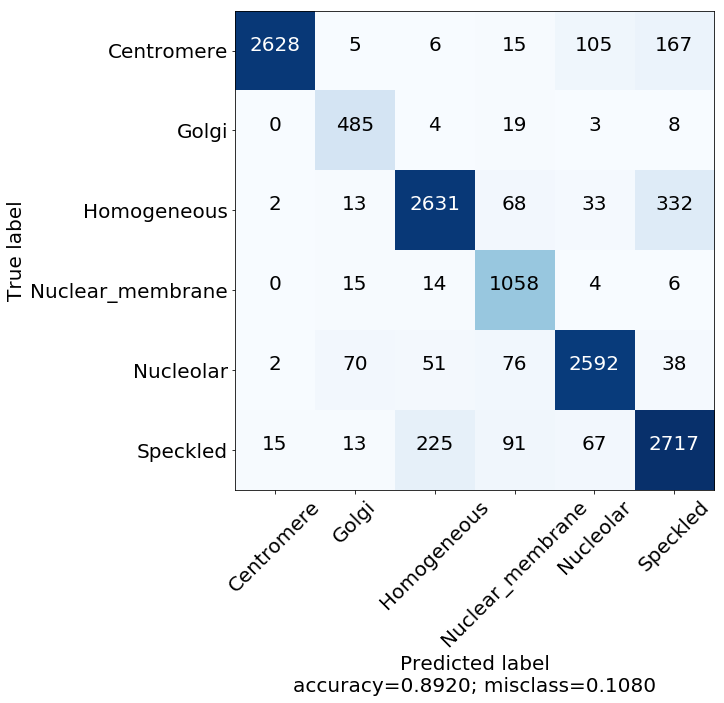

In [25]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[2628    5    6   15  105  167]
 [   0  485    4   19    3    8]
 [   2   13 2631   68   33  332]
 [   0   15   14 1058    4    6]
 [   2   70   51   76 2592   38]
 [  15   13  225   91   67 2717]]
                  precision    recall  f1-score   support

       Nucleolar       0.99      0.90      0.94      2926
     Homogeneous       0.81      0.93      0.87       519
Nuclear_membrane       0.90      0.85      0.88      3079
      Centromere       0.80      0.96      0.87      1097
        Speckled       0.92      0.92      0.92      2829
           Golgi       0.83      0.87      0.85      3128

       micro avg       0.89      0.89      0.89     13578
       macro avg       0.88      0.91      0.89     13578
    weighted avg       0.90      0.89      0.89     13578



In [27]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  1.0
Specificity :  0.9897959183673469


In [28]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

13578/13578 [==============================] - 0s 24us/step
Precision =  0.8968930884617178
Recall =  0.8919575784357048
f1_score =  0.8928774811900209


In [29]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9333782934066084


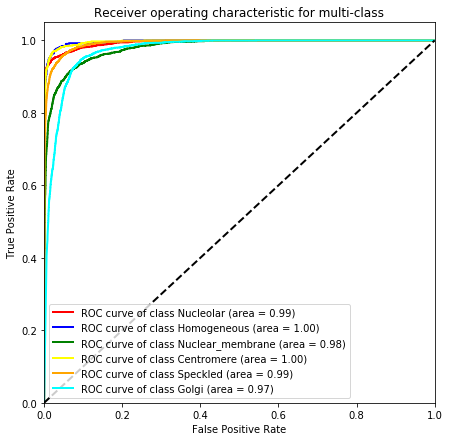

In [30]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle

predict_class = np.argmax(preds, axis=1)

y_pred = preds
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4, 5])
y_pred_binary = y_pred_probabilities
n_classes=6
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(7, 7))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

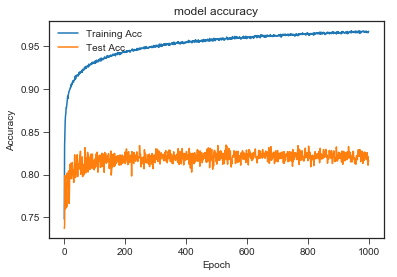

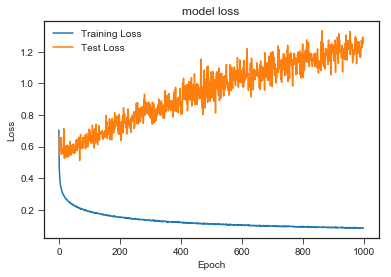

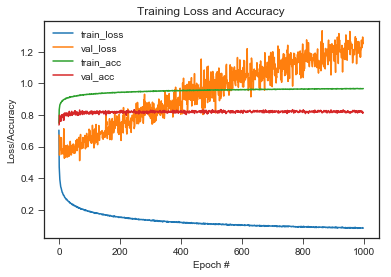

In [31]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")